# **I. Data Prep**
- Ingestion
- Cleaning
- Merging

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
energy_df = pd.read_csv('energy_dataset.csv')
weather_df = pd.read_csv('weather_features.csv')
energy_df.info()
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [ ]:
print(energy_df.head())
print(weather_df.head())

                        time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.

In [ ]:
print(energy_df.isnull().sum())
print(weather_df.isnull().sum())

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [ ]:
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)
energy_df.sort_values('time', inplace=True)

for col in energy_df.columns:
  if energy_df[col].isnull().sum() > 0:
    energy_df[col] = energy_df[col].interpolate(method='linear')

weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True)
print(weather_df['city_name'].unique())

['Valencia' 'Madrid' 'Bilbao' ' Barcelona' 'Seville']


In [ ]:
hourly_weather_avg = weather_df.groupby('dt_iso').agg({
    'temp': 'mean',
    'temp_min': 'mean',
    'temp_max': 'mean',
    'pressure': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'wind_deg': 'mean',
    'rain_1h': 'mean',
    'rain_3h': 'mean',
    'snow_3h': 'mean',
    'clouds_all': 'mean'
}).reset_index()

In [ ]:
hourly_weather_avg.rename(columns={'dt_iso': 'time'}, inplace=True)
merged_df = pd.merge(energy_df, hourly_weather_avg, on='time')

merged_df['year'] = merged_df['time'].dt.year
merged_df['month'] = merged_df['time'].dt.month
merged_df['day'] = merged_df['time'].dt.day
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['dayofweek'] = merged_df['time'].dt.dayofweek # Monday=0, Sunday=6

print(merged_df.info())

print(merged_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 45 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35064 non-null  float64            
 2   generation fossil brown coal/lignite         35064 non-null  float64            
 3   generation fossil coal-derived gas           35064 non-null  float64            
 4   generation fossil gas                        35064 non-null  float64            
 5   generation fossil hard coal                  35064 non-null  float64            
 6   generation fossil oil                        35064 non-null  float64            
 7   generation fossil oil shale                  35064 non-null  float64            
 8   generation fossil peat    

# **II. Exploratory Data Analysis (EDA)**

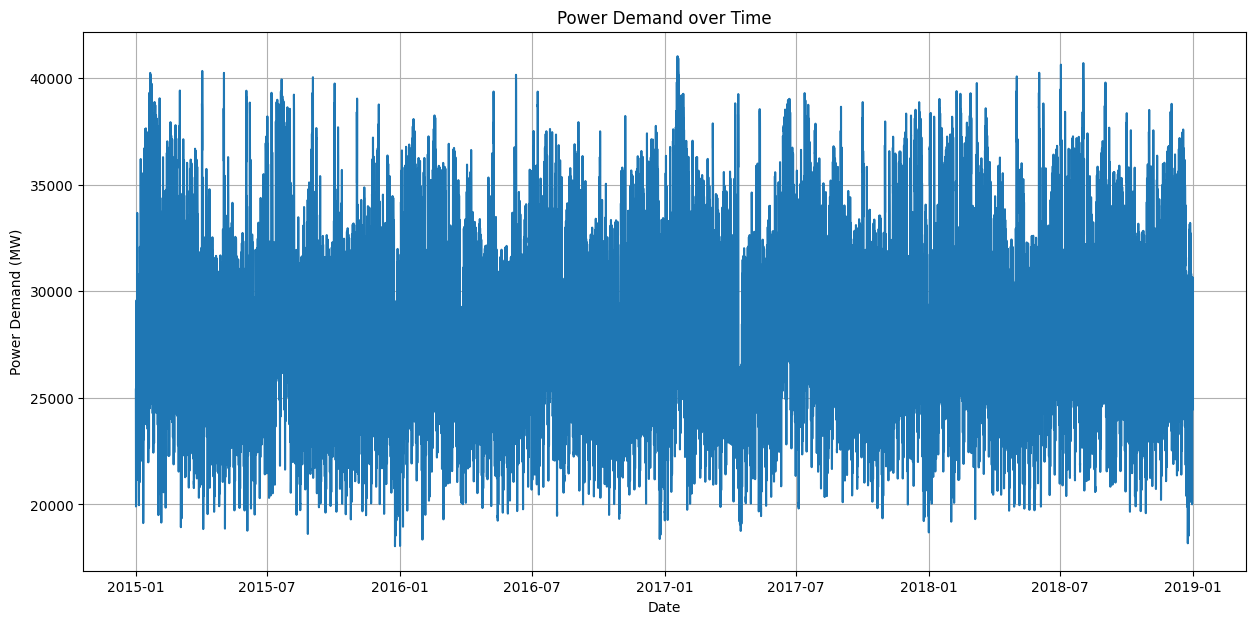

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(merged_df['time'], merged_df['total load actual'])
plt.title('Power Demand over Time')
plt.xlabel('Date')
plt.ylabel('Power Demand (MW)')
plt.grid(True)
plt.show()

The average power demand each day peaks during the 19th hour at around 32222.81 MW


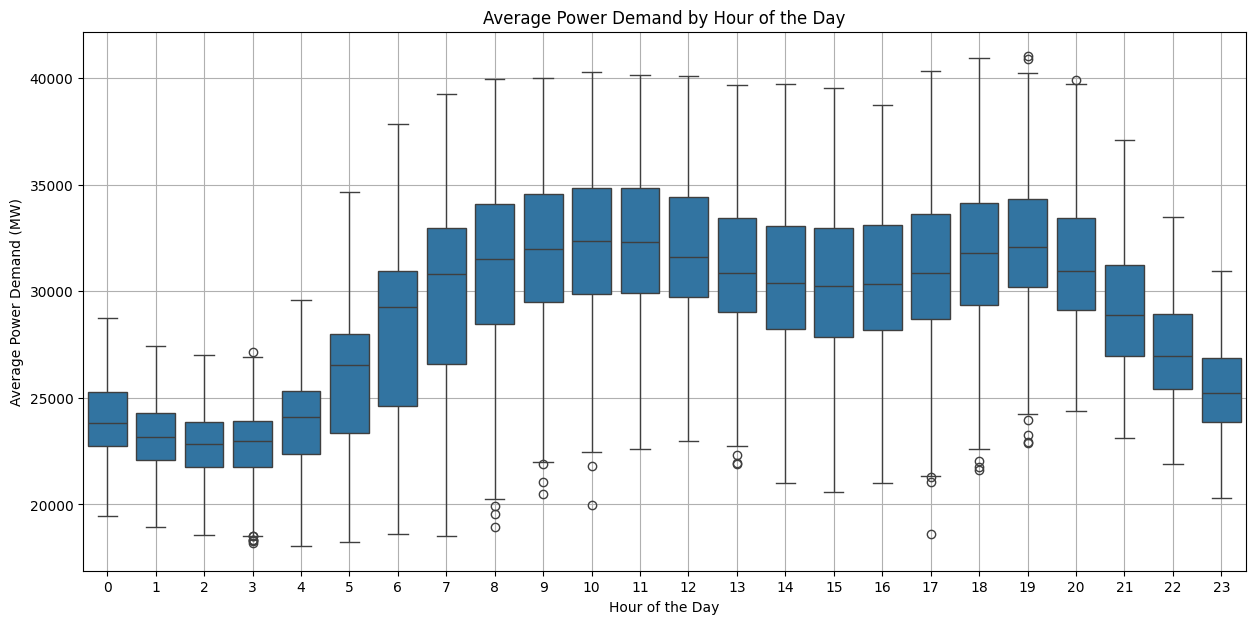

In [ ]:
plt.figure(figsize=(15, 7))
#sns.lineplot(x='hour', y='total load actual', data=merged_df.groupby('hour')['total load actual'].mean().reset_index())

sns.boxplot(x='hour', y='total load actual', data=merged_df)
plt.title('Average Power Demand by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Power Demand (MW)')
plt.grid(True)

max_power_demand_hour = merged_df.groupby('hour')['total load actual'].mean().idxmax()
max_power_demand_hour_value = round(merged_df.groupby('hour')['total load actual'].mean().max(), 2)

print(f"The average power demand each day peaks during the {max_power_demand_hour}th hour at around {max_power_demand_hour_value} MW")

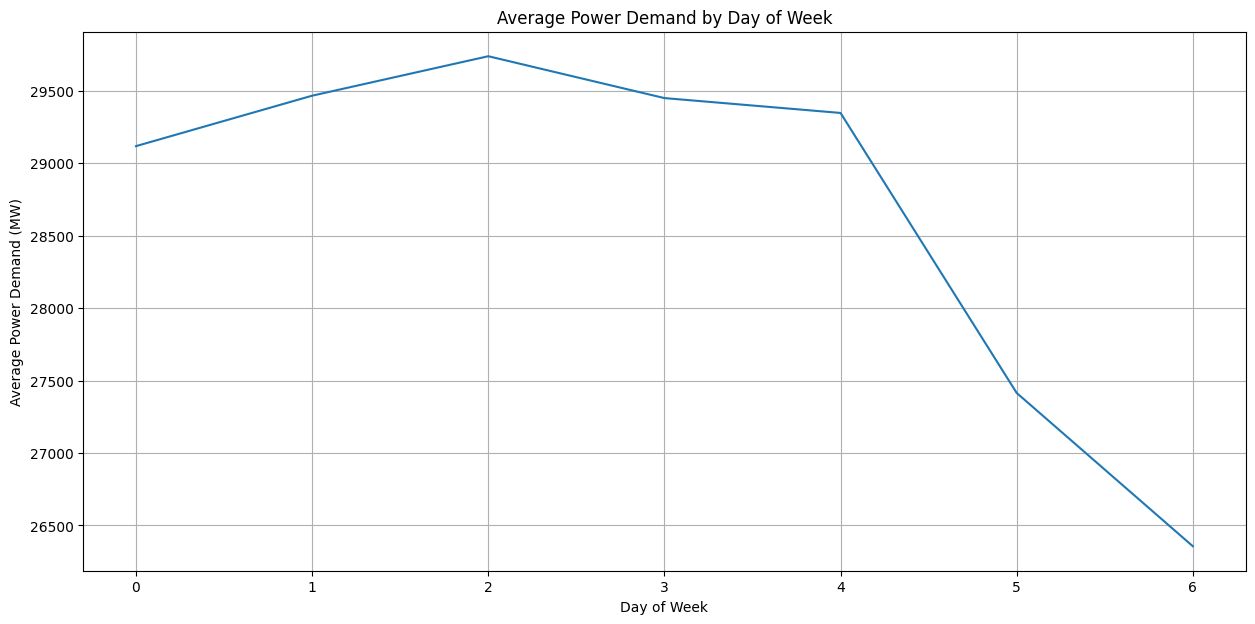

The average power demand each week peaks at the 2st day at around 29739.94 MW.
The 2nd day is a Tuesday.


In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='dayofweek', y='total load actual', data=merged_df.groupby('dayofweek')['total load actual'].mean().reset_index())
plt.title('Average Power Demand by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Power Demand (MW)')
plt.grid(True)
plt.show()

max_power_demand_day = merged_df.groupby('dayofweek')['total load actual'].mean().idxmax()
max_power_demand_day_value = round(merged_df.groupby('dayofweek')['total load actual'].mean().max(), 2)

print(f"The average power demand each week peaks at the {max_power_demand_day}st day at around {max_power_demand_day_value} MW.")
print(f"The {max_power_demand_day}nd day is a Tuesday.")

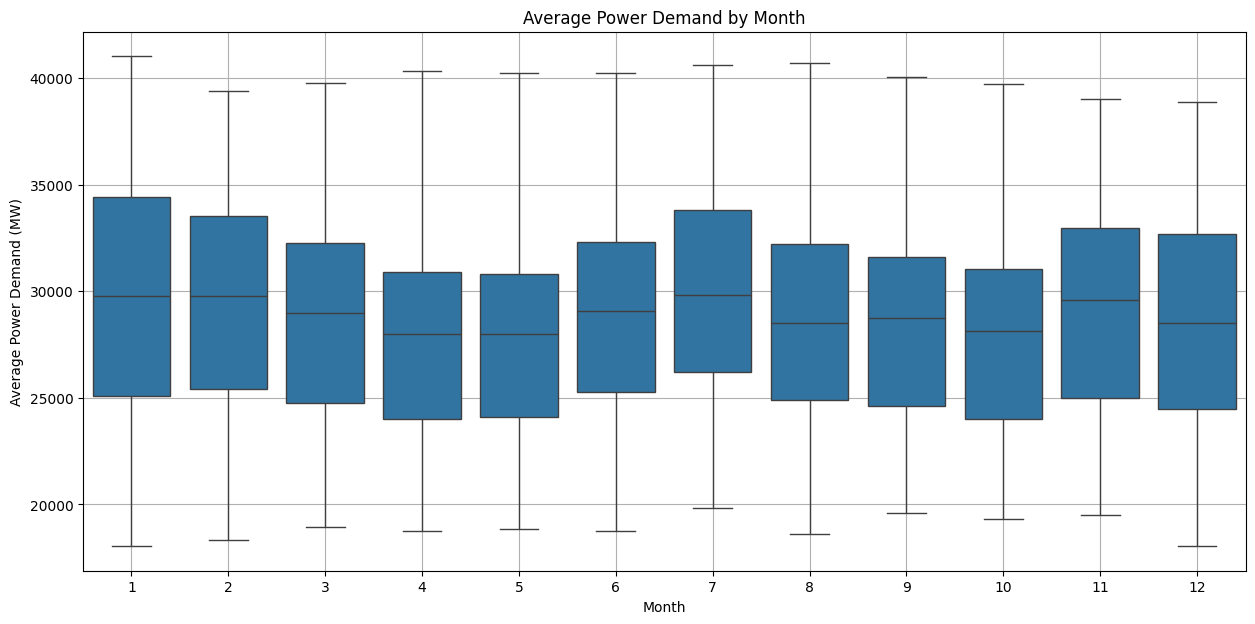

The average power demand each year peaks during the 7th month at around 29932.63 MW.
The highest power demand each year peaks during the 1st month at around 41015.0 MW.


In [ ]:
plt.figure(figsize=(15, 7))
sns.boxplot(x='month', y='total load actual', data=merged_df)
plt.title('Average Power Demand by Month')
plt.xlabel('Month')
plt.ylabel('Average Power Demand (MW)')
plt.grid(True)
plt.show()

max_ave_power_demand_month = merged_df.groupby('month')['total load actual'].mean().idxmax()
max_ave_power_demand_month_value = round(merged_df.groupby('month')['total load actual'].mean().max(), 2)

max_power_demand_month = int(merged_df.loc[merged_df['total load actual'].idxmax()]['month'])
max_power_demand_month_value = round(merged_df['total load actual'].max(), 2)

print(f"The average power demand each year peaks during the {max_ave_power_demand_month}th month at around {max_ave_power_demand_month_value} MW.")
print(f"The highest power demand each year peaks during the {max_power_demand_month}st month at around {max_power_demand_month_value} MW.")

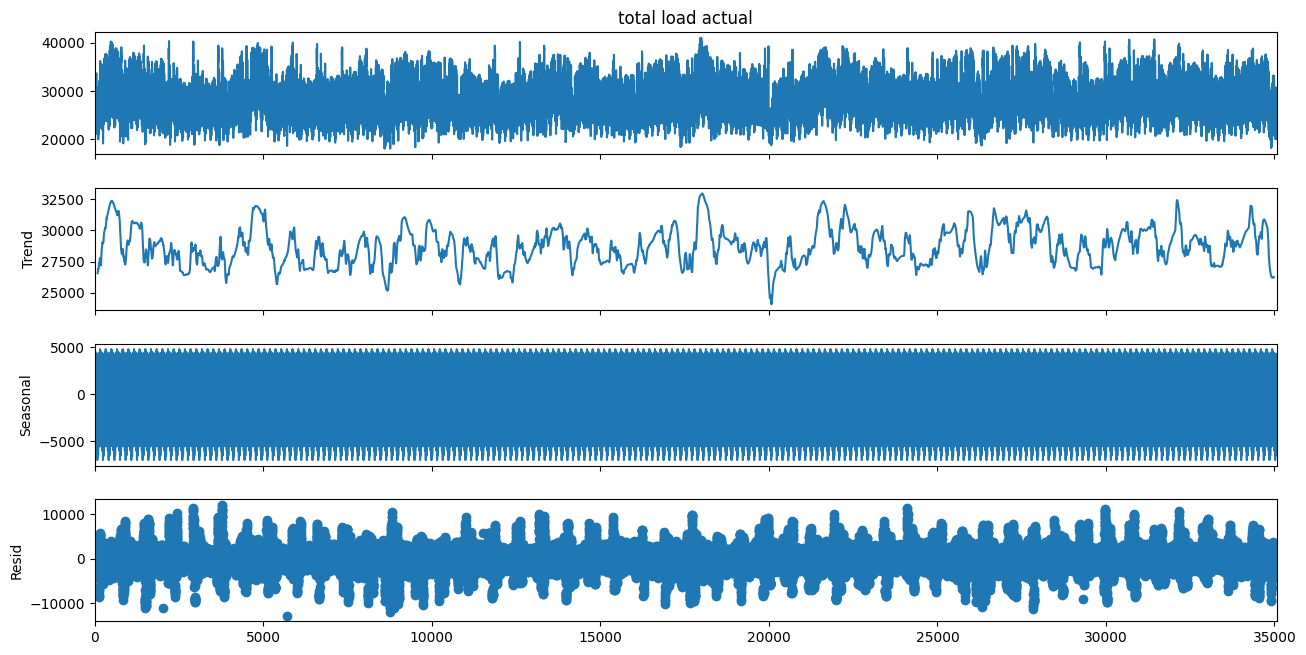

In [ ]:
seasonality = seasonal_decompose(merged_df['total load actual'], model='additive', period=24*7)
fig = seasonality.plot()
fig.set_size_inches(15, 7)
plt.show()

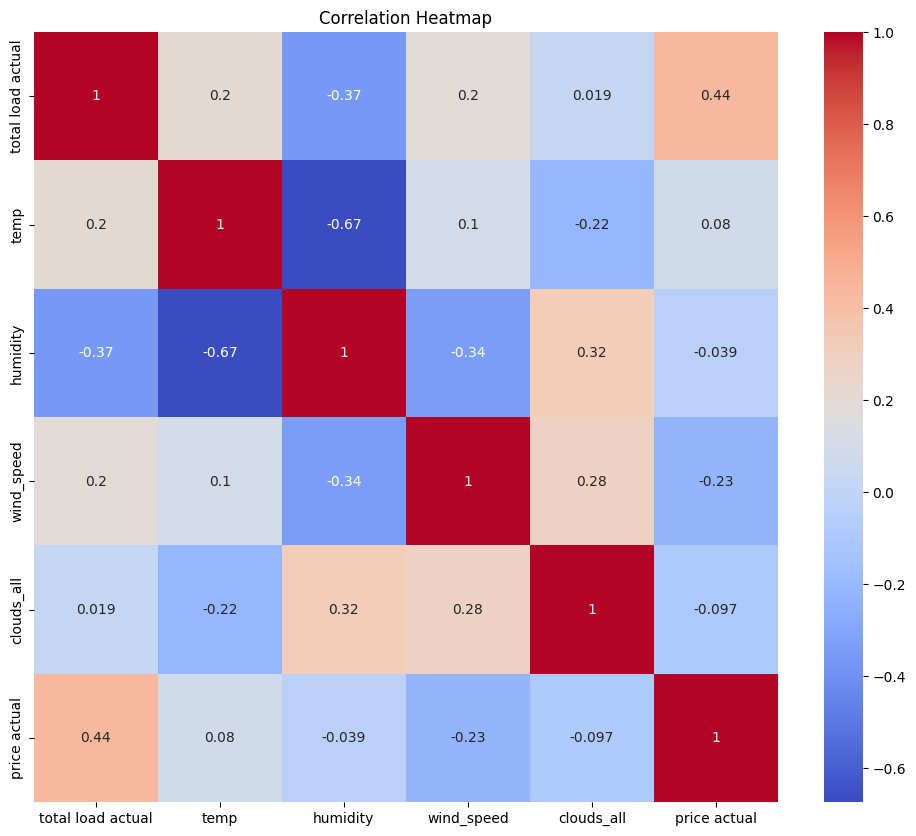

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(merged_df[['total load actual', 'temp', 'humidity', 'wind_speed', 'clouds_all', 'price actual']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

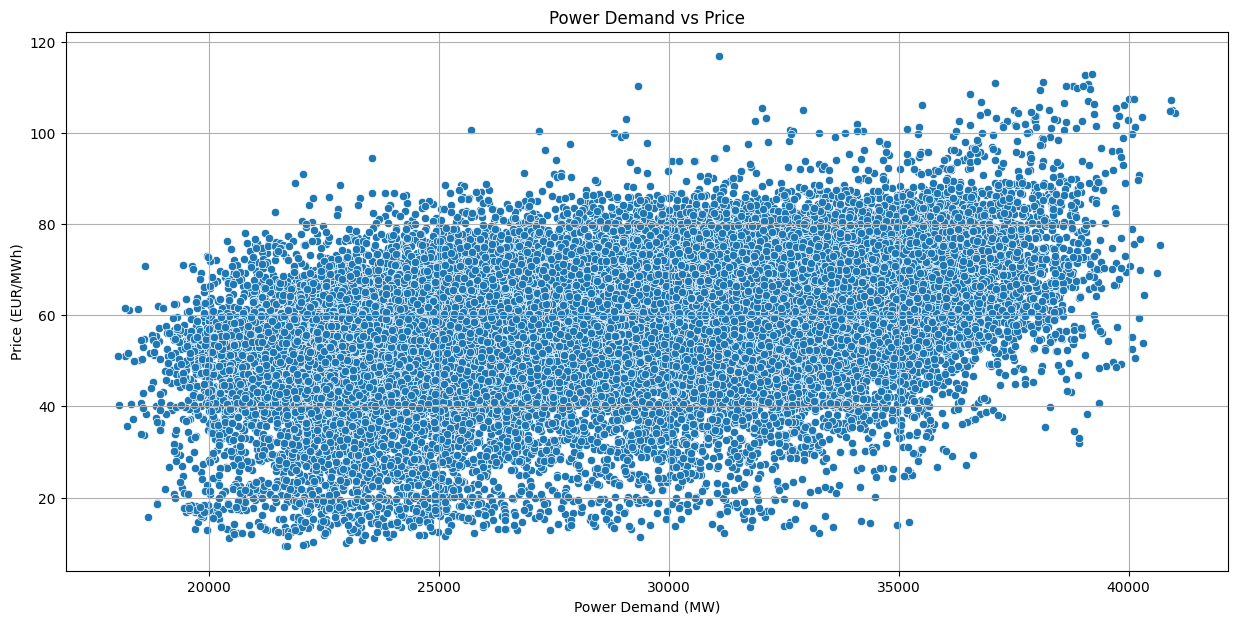

In [ ]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x='total load actual', y='price actual', data=merged_df)
plt.title('Power Demand vs Price')
plt.ylabel('Price (EUR/MWh)')
plt.xlabel('Power Demand (MW)')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Wind Speed vs. Power Demand')

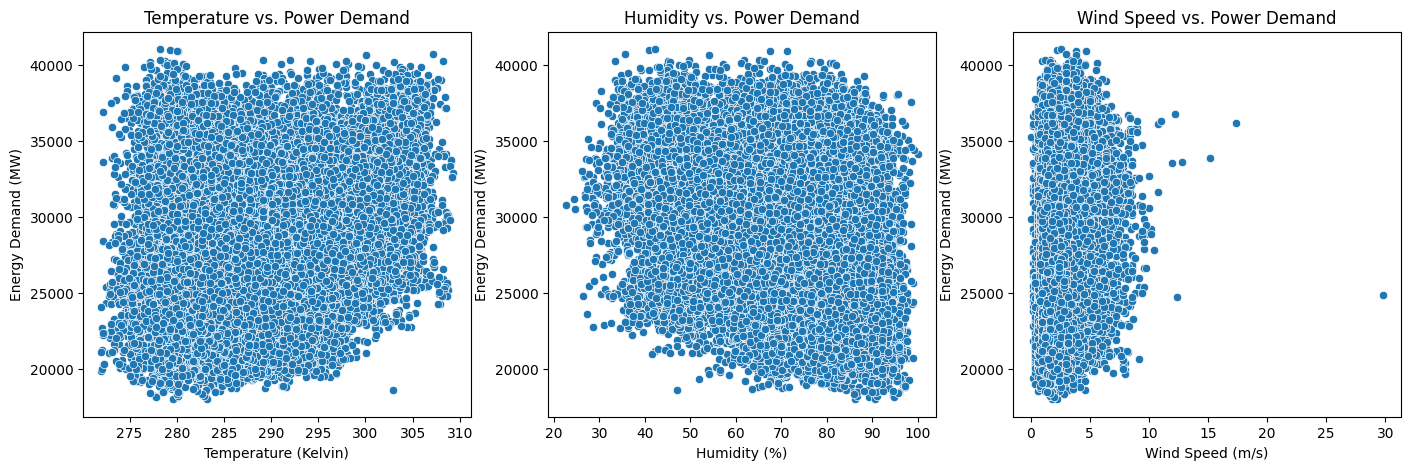

In [ ]:
plt.figure(figsize=(17, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='temp', y='total load actual', data=merged_df)
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Energy Demand (MW)')
plt.title('Temperature vs. Power Demand')

plt.subplot(1, 3, 2)
sns.scatterplot(x='humidity', y='total load actual', data=merged_df)
plt.xlabel('Humidity (%)')
plt.ylabel('Energy Demand (MW)')
plt.title('Humidity vs. Power Demand')

plt.subplot(1, 3, 3)
sns.scatterplot(x='wind_speed', y='total load actual', data=merged_df)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Energy Demand (MW)')
plt.title('Wind Speed vs. Power Demand')

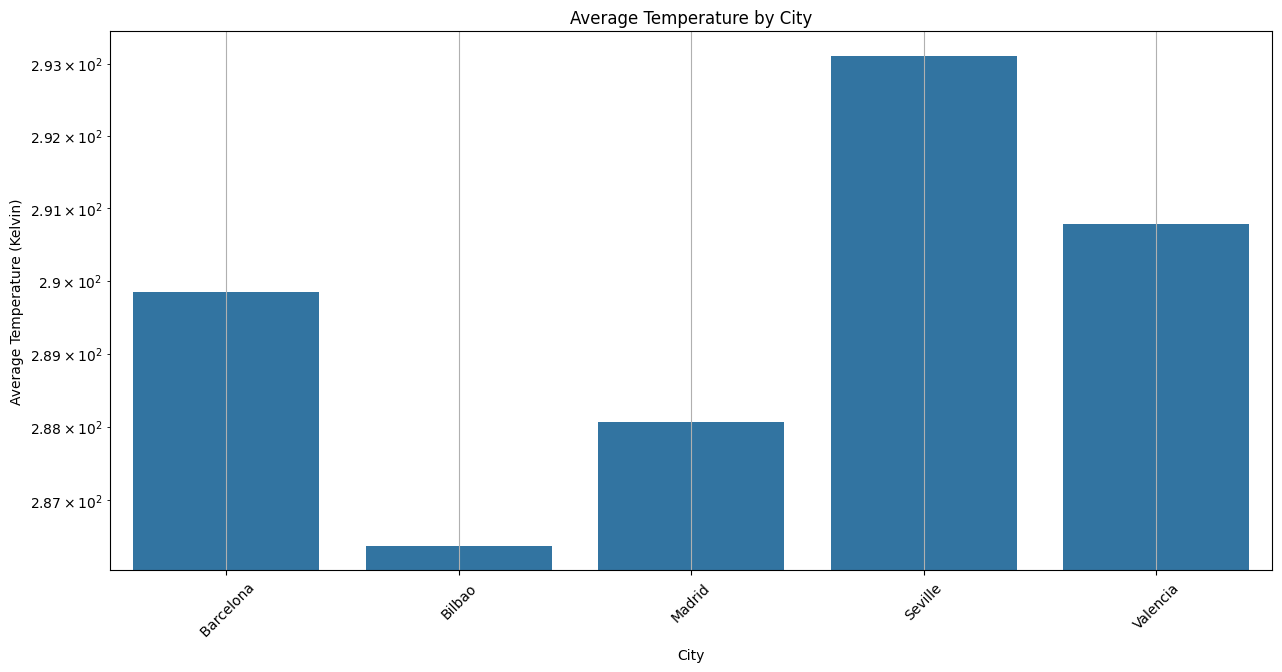

In [ ]:
weather_by_city_df = weather_df.groupby('city_name')[['temp', 'humidity', 'wind_speed']].mean()

plt.figure(figsize=(15, 7))
sns.barplot(x='city_name', y='temp', data=weather_by_city_df.reset_index())
plt.title('Average Temperature by City')
plt.xlabel('City')
plt.yscale('log')
plt.ylabel('Average Temperature (Kelvin)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# **III. Model Building**

**III.a. Feature Engineering and Splitting**

In [ ]:
merged_df = merged_df.set_index('time')

merged_df['hour'] = merged_df.index.hour
merged_df['dayofweek'] = merged_df.index.dayofweek
merged_df['quarter'] = merged_df.index.quarter
merged_df['month'] = merged_df.index.month
merged_df['year'] = merged_df.index.year
merged_df['dayofyear'] = merged_df.index.dayofyear

train_size = int(len(merged_df) * 0.8)
train, test = merged_df.iloc[:train_size], merged_df.iloc[train_size:len(merged_df)]

**III.b. Model 1: Random Forest**

In [ ]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'temp', 'humidity', 'wind_speed', 'clouds_all']
target = 'total load actual'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [ ]:
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

In [ ]:
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest MAPE: {rf_mape}")

Random Forest RMSE: 2398.814074974566
Random Forest MAPE: 0.05662438408307061


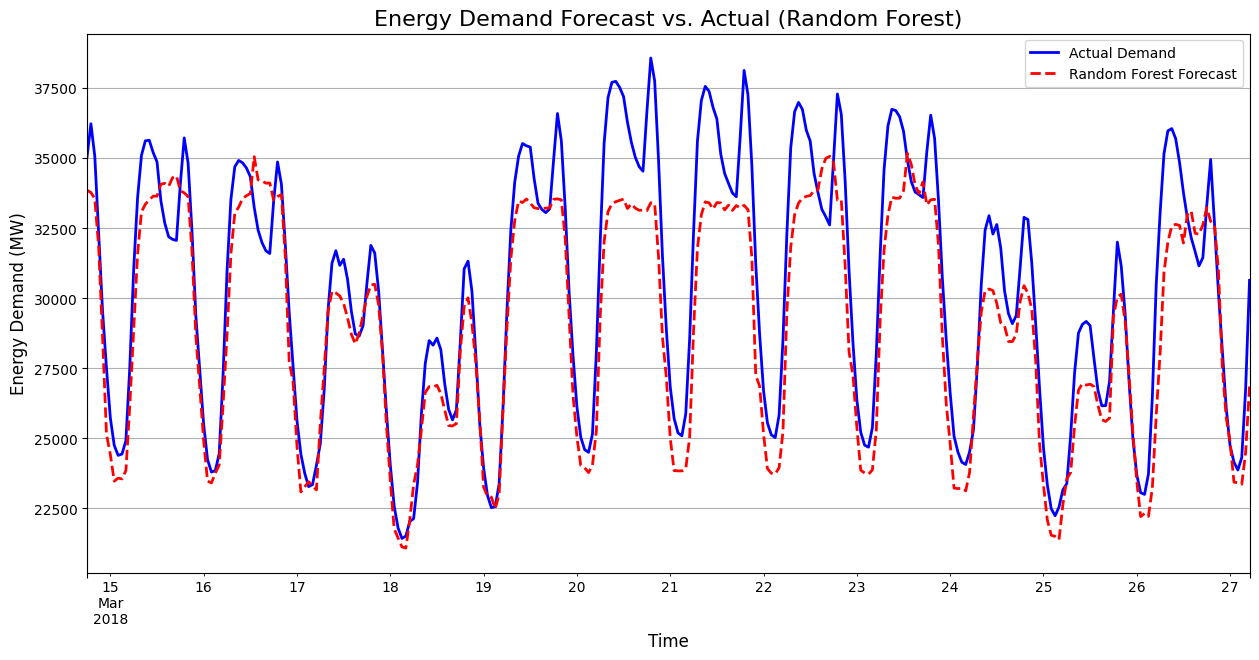

In [ ]:
rf_results_df = pd.DataFrame({
    'Actual Demand': y_test,
    'Random Forest Forecast': rf_predictions
}, index=y_test.index)


plt.figure(figsize=(15, 7))
rf_results_df['Actual Demand'].head(300).plot(label='Actual Demand', color='blue', linewidth=2)
rf_results_df['Random Forest Forecast'].head(300).plot(label='Random Forest Forecast', color='red', linestyle='--', linewidth=2)

plt.title('Energy Demand Forecast vs. Actual (Random Forest)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**III.c. Model 2: XGBoost**

In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False
)

xgb_predictions = xgb_model.predict(X_test)

In [ ]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost MAPE: {xgb_mape}")

XGBoost RMSE: 2337.387388372847
XGBoost MAPE: 0.057557312938736574


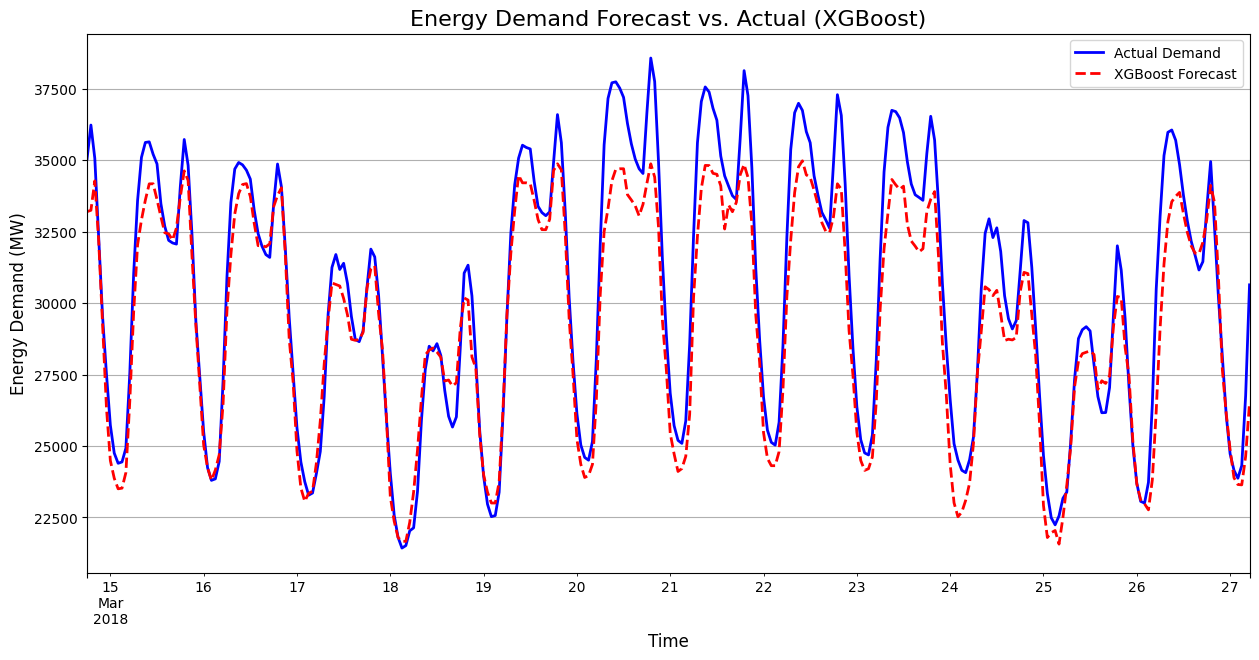

In [ ]:
xgb_results_df = pd.DataFrame({
    'Actual Demand': y_test,
    'XGBoost Forecast': xgb_predictions
}, index=y_test.index)


plt.figure(figsize=(15, 7))
xgb_results_df['Actual Demand'].head(300).plot(label='Actual Demand', color='blue', linewidth=2)
xgb_results_df['XGBoost Forecast'].head(300).plot(label='XGBoost Forecast', color='red', linestyle='--', linewidth=2)

plt.title('Energy Demand Forecast vs. Actual (XGBoost)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**III.d. Model 3: SARIMAX**

In [ ]:
sarimax_train_subset = train.iloc[-1000:]
sarimax_test_subset = test.iloc[:300]

exog_features = ['temp', 'humidity', 'wind_speed']
exog_train = sarimax_train_subset[exog_features]
exog_test = sarimax_test_subset[exog_features]

sarimax_model = SARIMAX(sarimax_train_subset['total load actual'],
exog=exog_train,
order=(2, 1, 2),
seasonal_order=(1, 1, 1, 24),
enforce_stationarity=False,
enforce_invertibility=False)

sarimax_results = sarimax_model.fit(disp=False)
sarimax_predictions = sarimax_results.get_forecast(steps=len(sarimax_test_subset), exog=exog_test).predicted_mean

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
sarimax_rmse = np.sqrt(mean_squared_error(sarimax_test_subset['total load actual'], sarimax_predictions))
sarimax_mape = mean_absolute_percentage_error(sarimax_test_subset['total load actual'], sarimax_predictions)

print(f"SARIMAX RMSE: {sarimax_rmse}")
print(f"SARIMAX MAPE: {sarimax_mape}")

SARIMAX RMSE: 2507.0750919906754
SARIMAX MAPE: 0.06595378708162541


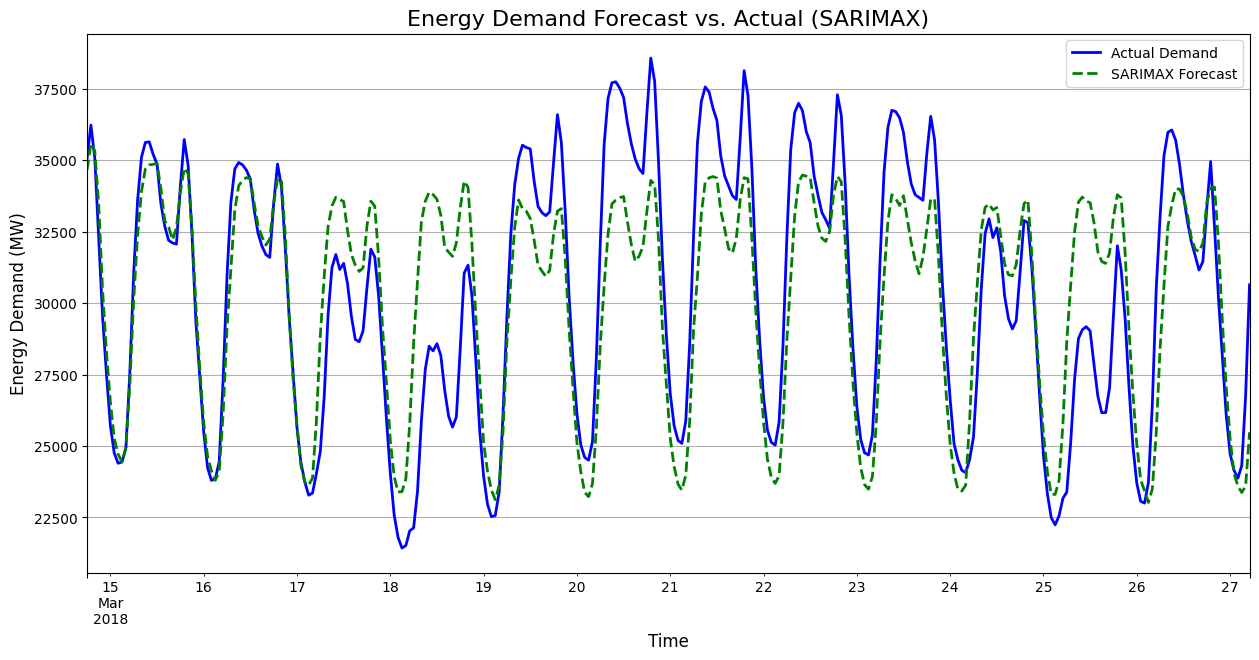

In [ ]:
actuals = sarimax_test_subset['total load actual'].tail(300)

plt.figure(figsize=(15, 7))
actuals.plot(label='Actual Demand', color='blue', linewidth=2)
sarimax_predictions.plot(label='SARIMAX Forecast', color='green', linestyle='--', linewidth=2)

plt.title('Energy Demand Forecast vs. Actual (SARIMAX)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Energy Demand (MW)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()